In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

pd.set_option('display.max.columns', None)

### Entendendo os Datasets

In [3]:
df_orders = pd.read_csv('olist_orders_dataset.csv')
df_customers = pd.read_csv('olist_customers_dataset.csv') # dados do cliente
df_geolocation = pd.read_csv('olist_geolocation_dataset.csv')
df_items = pd.read_csv('olist_order_items_dataset.csv') # dados do produto que foi pedido
df_payments = pd.read_csv('olist_order_payments_dataset.csv') # dados do pagamento
df_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
df_products = pd.read_csv('olist_products_dataset.csv') # descrição de cada produto
df_sellers = pd.read_csv('olist_sellers_dataset.csv') # descrição de cada vendedor
df_translation= pd.read_csv('product_category_name_translation.csv')

In [4]:
df_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [5]:
lista_name = ['orders','customers','geolocation','items','payments','reviews','products','sellers','translation']
dfs = [df_orders, df_customers, df_geolocation, df_items, df_payments, df_reviews, df_products, df_sellers, df_translation]

dict_nomes = dict(zip(lista_name, dfs))

In [6]:
for name, df in dict_nomes.items():
    for column in df.columns:
        if df[column].isnull().sum() != 0:  # Verifica quais colunas de qual dataframe tem valores nulos
            print(f'{name} - {column}')

orders - order_approved_at
orders - order_delivered_carrier_date
orders - order_delivered_customer_date
reviews - review_comment_title
reviews - review_comment_message
products - product_category_name
products - product_name_lenght
products - product_description_lenght
products - product_photos_qty
products - product_weight_g
products - product_length_cm
products - product_height_cm
products - product_width_cm


Alguns parâmetros são possíveis deduzir a razão de apresentarem valores faltantes, como os que são relacionados à situação de entrega por exemplo ('order_delivered_carrier_date', 'order_delivered_customer_date'), são pedidos em que a compra não foi finalizada; ou os relacionados às avaliações ('review_comment_title', 'review_comment_title') também são deduzíveis, porém outros não são tão intuitivos, necessitando de uma melhor análise.

In [7]:
df_products.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [8]:
df_products[df_products.product_category_name.isnull()].product_name_lenght.unique()

array([nan])

O código acima mostra que todos os produtos sem categoria também não possuem nome e, consequentemente, não há tamanho de nome, descrição ou quantidade de fotos pois não podem ser reconhecidos.

#### Criando um dataset consolidado

In [9]:
df_items_products = df_items.merge(df_products, how='left', on='product_id')

In [10]:
df_items_products_sellers = df_items_products.merge(df_sellers, how='left', on='seller_id')

In [11]:
df_order_payments = df_orders.merge(df_payments, how='left', on='order_id')

In [12]:
df_order_payments_customers = df_order_payments.merge(df_customers, how='left', on='customer_id')

In [13]:
df_order_payments_customers_reviews = df_order_payments_customers.merge(df_reviews, how='left', on='order_id')

In [14]:
df_consolidado = df_items_products_sellers.merge(df_order_payments_customers_reviews, how='outer', on='order_id')

In [15]:
df_consolidado.shape


(119143, 39)

In [16]:
# total de valores missing

df_consolidado.isnull().sum()

order_id                              0
order_item_id                       833
product_id                          833
seller_id                           833
shipping_limit_date                 833
price                               833
freight_value                       833
product_category_name              2542
product_name_lenght                2542
product_description_lenght         2542
product_photos_qty                 2542
product_weight_g                    853
product_length_cm                   853
product_height_cm                   853
product_width_cm                    853
seller_zip_code_prefix              833
seller_city                         833
seller_state                        833
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                   177
order_delivered_carrier_date       2086
order_delivered_customer_date      3421
order_estimated_delivery_date         0


Com a criação de um dataset consolidado apareceram parâmetros com valores faltantes que antes não apresentavam, como 'order_item_id' e 'payment_type' e que precisam ser investigados.

In [17]:
df_consolidado[df_consolidado.order_item_id.isnull()]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
118310,8e24261a7e58791d10cb1bf9da94df5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaN,NaN,2017-12-05 00:00:00,1.0,credit_card,5.0,84.00,41fc647b8c6bd979b1b6364b60471b50,89288,sao bento do sul,SC,7fb04ba6e8b915c62557517d5c1e04ee,1.0,NaN,Anunciam um produto que não tem em estoque e a...,2017-12-07 00:00:00,2017-12-11 10:37:57
118311,c272bcd21c287498b4883c7512019702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaN,NaN,2018-02-16 00:00:00,1.0,credit_card,1.0,97.68,0e634b16e4c585acbd7b2e8276ce6677,11701,praia grande,SP,b6ea5566d6060db04ebe53a1291e4541,3.0,NaN,NaN,2018-02-18 00:00:00,2018-02-20 19:23:56
118312,37553832a3a89c9b2db59701c357ca67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaN,NaN,2017-09-05 00:00:00,1.0,boleto,1.0,132.46,596ed6d7a35890b3fbac54ec01f69685,2318,sao paulo,SP,aaeb804fe1828db8cc3d8b52ec38a1fa,1.0,NaN,Até hoje não recebi meu produto e nem uma resp...,2017-09-10 00:00:00,2017-09-12 17:00:15
118313,d57e15fb07fd180f06ab3926b39edcd2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaN,NaN,2018-02-06 00:00:00,1.0,boleto,1.0,134.38,2349bbb558908e0955e98d47dacb7adb,48607,paulo afonso,BA,519e62c42f33dce5b47ffddf9fde28df,1.0,NaN,Não compre,2018-02-09 00:00:00,2018-02-09 03:22:43
118314,00b1cb0320190ca0daa2c88b35206009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaN,NaN,NaN,2018-09-12 00:00:00,1.0,not_defined,1.0,0.00,4fa4365000c7090fcb8cad5713c6d3db,1151,sao paulo,SP,9c0d840dfe562debfa52a1792bd64bff,1.0,Entregaram produto errado,Comprei dois fones de ouvido com valor de R$ 5...,2018-08-28 00:00:00,2018-08-28 18:25:55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119138,aaab15da689073f8f9aa978a390a69d1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaN,NaN,2018-02-06 00:00:00,1.0,boleto,1.0,210.09,a33e0969408919ba06779f497ead93ec,7025,guarulhos,SP,396e26da77b10734f3f8b5d5515fef4e,1.0,NaN,"UMA BOSTA NAO ENTREGA, E NAO FAZ ESTORNO DO VA...",2018-02-09 00:00:00,2018-02-09 10:12:45
119139,3a3cddda5a7c27851bd96c3313412840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaN,NaN,NaN,2018-10-01 00:00:00,1.0,voucher,1.0,63.89,e90598185d2427a35e32ef241a5c04aa,11075,santos,SP,16d3db296c46b4411dfc5f8bde882e6d,5.0,NaN,NaN,2018-07-24 00:00:00,2018-07-25 16:26:05
119140,a89abace0dcc01eeb267a9660b5ac126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaN,NaN,NaN,2018-09-27 00:00:00,1.0,voucher,1.0,107.13,d05c44a138277ad325d915c6b7ccbcdf,5344,sao paulo,SP,047fd109c

In [18]:
df_consolidado[df_consolidado.order_status.isin(['unavailable', 'canceled'])].isnull().sum()

order_id                            0
order_item_id                     825
product_id                        825
seller_id                         825
shipping_limit_date               825
price                             825
freight_value                     825
product_category_name             840
product_name_lenght               840
product_description_lenght        840
product_photos_qty                840
product_weight_g                  825
product_length_cm                 825
product_height_cm                 825
product_width_cm                  825
seller_zip_code_prefix            825
seller_city                       825
seller_state                      825
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 157
order_delivered_carrier_date     1322
order_delivered_customer_date    1395
order_estimated_delivery_date       0
payment_sequential                  0
payment_type

DOs 830 valores faltantes em 'order_item_id', 'product_id', etc, 822 são devido a pedidos com 'order_status' igual a 'unavailable' ou 'canceled'.

In [19]:
# 8 pedidos que sobraram com order_item_id nulos
df_consolidado[(df_consolidado.order_item_id.isnull()) & (~df_consolidado.order_status.isin(['unavailable', 'canceled']))]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
118369,b5359909123fa03c50bdb0cfed07f098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,438449d4af8980d107bf04571413a8e7,created,2017-12-05 01:07:52,NaN,NaN,NaN,2018-01-11 00:00:00,1.0,credit_card,10.0,160.94,55fbb57fd54c35a38c80c2a032a6ca6e,15300,general salgado,SP,094b5d5ffff5d37b6195b4674ac84362,1.0,NaN,o PRODUTO NÃO CHEGOU ATÉ HOJE.,2018-01-13 00:00:00,2018-01-14 23:15:02
118387,dba5062fbda3af4fb6c33b1e040ca38f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,964a6df3d9bdf60fe3e7b8bb69ed893a,created,2018-02-09 17:21:04,NaN,NaN,NaN,2018-03-07 00:00:00,1.0,boleto,1.0,137.60,2e015e68fbfa36910263df5384e8e45c,73401,brasilia,DF,NaN,NaN,NaN,NaN,NaN,NaN
118482,7a4df5d8cff4090e541401a20a22bb80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,725e9c75605414b21fd8c8d5a1c2f1d6,created,2017-11-25 11:10:33,NaN,NaN,NaN,2017-12-12 00:00:00,1.0,boleto,1.0,37.84,355862aa14375fe3950ee04fef9c7a53,22621,rio de janeiro,RJ,64b53acf68ca2e45eebb01436a911982,1.0,NaN,NaN,2017-12-15 00:00:00,2017-12-15 13:33:49
118494,a68ce1686d536ca72bd2dadc4b8671e5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d7bed5fac093a4136216072abaf599d5,shipped,2016-10-05 01:47:40,2016-10-07 03:11:22,2016-11-07 16:37:37,NaN,2016-12-01 00:00:00,1.0,boleto,1.0,77.73,f15a952dfc52308d0361288fbf42c7b3,91250,porto alegre,RS,b399a4b417fc794a814ef957423bd67a,1.0,NaN,Comprei o produto dia 06/10/2016 hj é 15/12/20...,2016-12-07 00:00:00,2016-12-15 19:57:06
118782,35de4050331c6c644cddc86f4f2d0d64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4ee64f4bfc542546f422da0aeb462853,created,2017-12-05 01:07:58,NaN,NaN,NaN,2018-01-08 00:00:00,1.0,credit_card,7.0,105.87,10d5890ed5e7ec78a7db23b5ac579b17,93025,sao leopoldo,RS,NaN,NaN,NaN,NaN,NaN,NaN
118801,2ce9683175cdab7d1c95bcbb3e36f478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b2d7ae0415dbbca535b5f7b38056dd1f,invoiced,2016-10-05 21:03:33,2016-10-06 07:46:39,NaN,NaN,2016-11-25 00:00:00,1.0,boleto,1.0,73.04,6a2da481aa7827b951175772a0fe8bb8,16012,aracatuba,SP,17bc0bc3207616ee37afd4a39b10054a,1.0,NaN,"meu produto não chegou ,prazo de entrega de 34...",2016-11-27 00:00:00,2016-12-04 00:03:47
118806,90ab3e7d52544ec7bc3363c82689965f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7d61b9f4f216052ba664f22e9c504ef1,created,2017-11-06 13:12:34,NaN,NaN,NaN,2017-12-01 00:00:00,1.0,credit_card,6.0,245.85,161e5b2b4513edb336986a8909218365,87720,paranavai,PR,ce24a21f96199f7e7257d5346f387e5f,5.0,NaN,Embora o produto estivesse em falta a empresa ...,2017-12-06 00:00:00,2017-12-06 10:17:34
118895,e04f1da1f48bf2bbffcf57b9824f76e1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0d00d77134cae4c58695086ad8d85100,invoiced,2016-10-05 13:22:20,2016-10-06 15:51:38,NaN,NaN,2016-11-29 00:00:00,1.0,credit_card,7.0,76.19,8886115442775dd8a20c2dcc921c7cc8,88070,florianopolis,SC,5a4f0fe15c7a914e40cabe9a06d81513,1.0,NaN,"Até agora não recebi o produto, e já foi desco...",2016-12-01 00:00:00,2016-12-03 11:24:52


In [20]:
# Pedidos com tipo de pagamento faltando (total de 3)
df_consolidado[df_consolidado.payment_type.isnull()]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
88637,bfbd0f9bdef84302105ad712db648a6c,1.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,34.0,1036.0,1.0,1000.0,16.0,16.0,16.0,81810.0,curitiba,PR,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00,NaN,NaN,NaN,NaN,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,6916ca4502d6d3bfd39818759d55d536,1.0,NaN,nao recebi o produto e nem resposta da empresa,2016-10-06 00:00:00,2016-10-07 18:32:28
88638,bfbd0f9bdef84302105ad712db648a6c,2.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,34.0,1036.0,1.0,1000.0,16.0,16.0,16.0,81810.0,curitiba,PR,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00,NaN,NaN,NaN,NaN,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,6916ca4502d6d3bfd39818759d55d536,1.0,NaN,nao recebi o produto e nem resposta da empresa,2016-10-06 00:00:00,2016-10-07 18:32:28
88639,bfbd0f9bdef84302105ad712db648a6c,3.0,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,34.0,1036.0,1.0,1000.0,16.0,16.0,16.0,81810.0,curitiba,PR,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00,NaN,NaN,NaN,NaN,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,6916ca4502d6d3bfd39818759d55d536,1.0,NaN,nao recebi o produto e nem resposta da empresa,2016-10-06 00:00:00,2016-10-07 18:32:28


Verifica-se que é um cliente que pediu três produtos iguais. Neste caso pode ser que tenha ocorrido algum erro na hora de apurar os dados de pagamento ou o cliente pode ter dado um golpe e não ter pago o produto.

Entendido a razão de valores faltantes, partiremos agora para analisar o dataset consolidado procurando responder a algumas perguntas de negócios.
- Qual categoria de produto que mais vende e seu faturamento?
- Qual categoria possuiu o maior faturamento?
- Qual estado possui mais clientes?
- Qual dia da semana que há mais vendas e a que horas?
- O valor do frete influencia na hora de finalizar a compra?
- Em qual estado o consumidor está pagando o frete mais caro?
- Qual tipo de pagamento mais utilizado?



#### 1 - Qual categoria de produto que mais vende e seu faturamento?

Text(0, 0.5, 'Quantidade de venda')

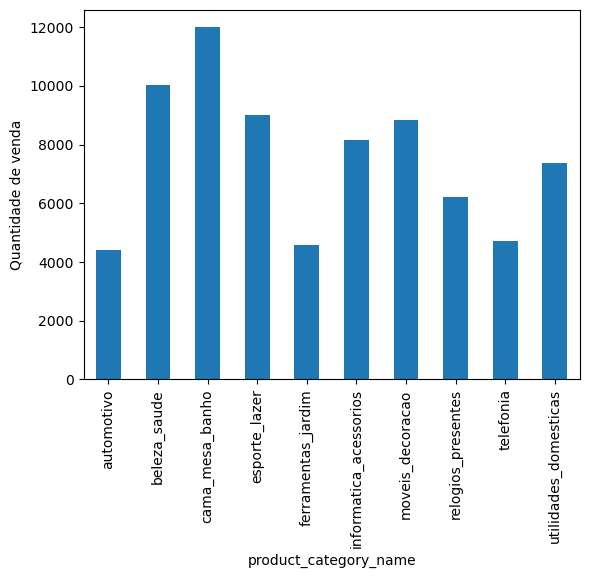

In [21]:
mais_vendas_top10 = df_consolidado.groupby('product_category_name').order_id.count().sort_values(ascending=False)[0:10]
mais_vendas_top10.sort_index().plot(kind='bar')
plt.ylabel('Quantidade de venda')

In [22]:
mais_vendas_top10.index

Index(['cama_mesa_banho', 'beleza_saude', 'esporte_lazer', 'moveis_decoracao',
       'informatica_acessorios', 'utilidades_domesticas', 'relogios_presentes',
       'telefonia', 'ferramentas_jardim', 'automotivo'],
      dtype='object', name='product_category_name')

Text(0, 0.5, 'Faturamento')

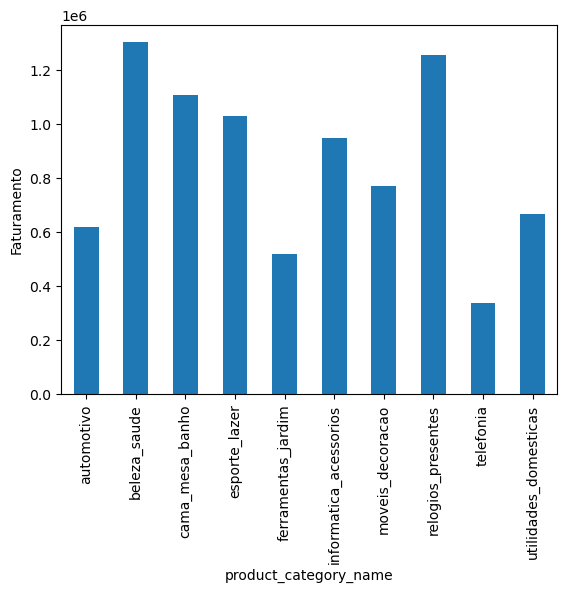

In [23]:
faturamento_top10_mais_vendas= df_consolidado[df_consolidado['product_category_name'].isin(mais_vendas_top10.index)].groupby('product_category_name').price.sum()
faturamento_top10_mais_vendas.plot(kind='bar')

plt.ylabel('Faturamento')


In [24]:
faturamento_top10_mais_vendas

product_category_name
automotivo                 618395.50
beleza_saude              1301947.97
cama_mesa_banho           1107249.09
esporte_lazer             1029603.88
ferramentas_jardim         519473.33
informatica_acessorios     950053.69
moveis_decoracao           772096.17
relogios_presentes        1254322.95
telefonia                  339571.03
utilidades_domesticas      668880.94
Name: price, dtype: float64

Podemos perceber que a categoria cama,mesa e banho foi a que possuiu mais produtos vendidos, com um faturamento de R$1.107.249,09

#### 2 - Qual categoria possuiu o maior faturamento?


Text(0, 0.5, 'Faturamento')

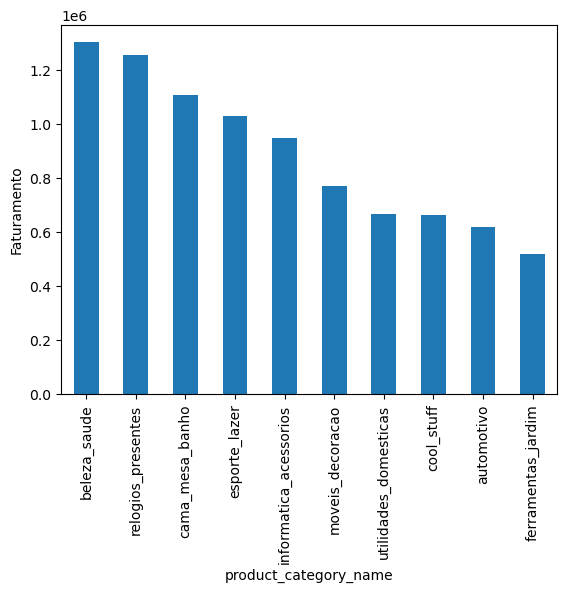

In [25]:
maior_faturamento_top10 = df_consolidado.groupby('product_category_name').price.sum().sort_values(ascending=False)[0:10]
maior_faturamento_top10.plot(kind='bar')

plt.ylabel('Faturamento')

In [26]:
maior_faturamento_top10

product_category_name
beleza_saude              1301947.97
relogios_presentes        1254322.95
cama_mesa_banho           1107249.09
esporte_lazer             1029603.88
informatica_acessorios     950053.69
moveis_decoracao           772096.17
utilidades_domesticas      668880.94
cool_stuff                 664637.13
automotivo                 618395.50
ferramentas_jardim         519473.33
Name: price, dtype: float64

A categoria que possuiu o maior faturamento foi a de beleza e saúde com um faturamento de R$1.301.947,97

#### 3 - Qual estado possui mais clientes?

In [27]:
df_consolidado.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277.0,volta redonda,SP,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,1.0,credit_card,2.0,72.19,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,97ca439bc427b48bc1cd7177abe71365,5.0,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03
1,00018f77f2f0320c557190d7a144bdd3,1.0,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,3471.0,sao paulo,SP,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,1.0,credit_card,3.0,259.83,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,7b07bacd811c4117b742569b04ce3580,4.0,NaN,NaN,2017-05-13 00:00:00,2017-05-15 11:34:13
2,000229ec398224ef6ca0657da4fc703e,1.0,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,37564.0,borda da mata,MG,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,1.0,credit_card,5.0,216.87,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,0c5b33dea94867d1ac402749e5438e8b,5.0,NaN,Chegou antes do prazo previsto e o produto sur...,2018-01-23 00:00:00,2018-01-23 16:06:31
3,00024acbcdf0a6daa1e931b038114c75,1.0,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,14403.0,franca,SP,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,1.0,credit_card,2.0,25.78,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,f4028d019cb58564807486a6aaf33817,4.0,NaN,NaN,2018-08-15 00:00:00,2018-08-15 16:39:01
4,00042b26cf59d7ce69dfabb4e55b4fd9,1.0,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,87900.0,loanda,PR,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,1.0,credit_card,3.0,218.04,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,940144190dcba6351888cafa43f3a3a5,5.0,NaN,Gostei pois veio no prazo determinado .,2017-03-02 00:00:00,2017-03-03 10:54:59


<AxesSubplot: xlabel='customer_state'>

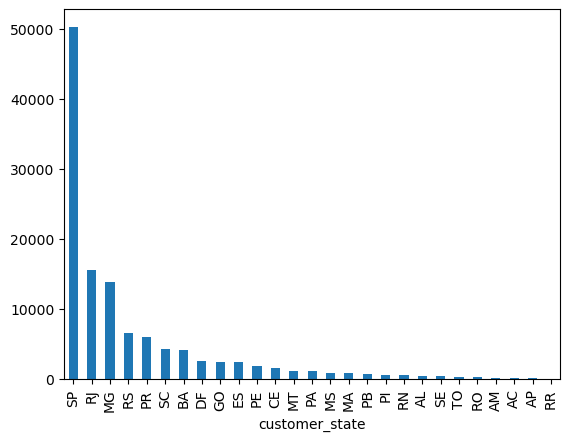

In [28]:
estados_com_mais_clientes = df_consolidado.groupby('customer_state').order_id.count().sort_values(ascending=False)
estados_com_mais_clientes.plot(kind='bar')

In [29]:
estados_com_mais_clientes[0:5]

customer_state
SP    50265
RJ    15518
MG    13819
RS     6573
PR     6043
Name: order_id, dtype: int64

O estado com mais clientes é o estado de SP. Com essa informação é possível traçar estratégias em relação a captação de clientes.

#### 4 - Qual dia da semana que há mais vendas e a que horas?


In [30]:
df_consolidado.order_status.value_counts()

delivered      115723
shipped          1256
canceled          750
unavailable       652
invoiced          378
processing        376
created             5
approved            3
Name: order_status, dtype: int64

Vamos considerar como venda todos os pedidos exceto com order_status igual a 'canceled' e 'unavailable'.

In [31]:
df_vendidos = df_consolidado[~df_consolidado['order_status'].isin(['canceled','unavailable'])]
df_vendidos.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277.0,volta redonda,SP,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,1.0,credit_card,2.0,72.19,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,97ca439bc427b48bc1cd7177abe71365,5.0,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03
1,00018f77f2f0320c557190d7a144bdd3,1.0,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,3471.0,sao paulo,SP,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,1.0,credit_card,3.0,259.83,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,7b07bacd811c4117b742569b04ce3580,4.0,NaN,NaN,2017-05-13 00:00:00,2017-05-15 11:34:13
2,000229ec398224ef6ca0657da4fc703e,1.0,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,37564.0,borda da mata,MG,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,1.0,credit_card,5.0,216.87,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,0c5b33dea94867d1ac402749e5438e8b,5.0,NaN,Chegou antes do prazo previsto e o produto sur...,2018-01-23 00:00:00,2018-01-23 16:06:31
3,00024acbcdf0a6daa1e931b038114c75,1.0,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,14403.0,franca,SP,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,1.0,credit_card,2.0,25.78,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,f4028d019cb58564807486a6aaf33817,4.0,NaN,NaN,2018-08-15 00:00:00,2018-08-15 16:39:01
4,00042b26cf59d7ce69dfabb4e55b4fd9,1.0,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,87900.0,loanda,PR,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,1.0,credit_card,3.0,218.04,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,940144190dcba6351888cafa43f3a3a5,5.0,NaN,Gostei pois veio no prazo determinado .,2017-03-02 00:00:00,2017-03-03 10:54:59


In [32]:
# Iremos usar como parâmetro a coluna order_purchase_timestamp
df_vendidos.order_purchase_timestamp.info()

<class 'pandas.core.series.Series'>
Int64Index: 117741 entries, 0 to 118895
Series name: order_purchase_timestamp
Non-Null Count   Dtype 
--------------   ----- 
117741 non-null  object
dtypes: object(1)
memory usage: 1.8+ MB


In [33]:
df_vendidos['order_purchase_timestamp'] = pd.to_datetime(df_vendidos['order_purchase_timestamp'], errors='coerce')

df_vendidos.order_purchase_timestamp.isnull().sum()

0

In [34]:
df_vendidos['day_of_the_week'] = df_vendidos['order_purchase_timestamp'].apply(lambda x: x.strftime('%A'))

<AxesSubplot: xlabel='day_of_the_week', ylabel='count'>

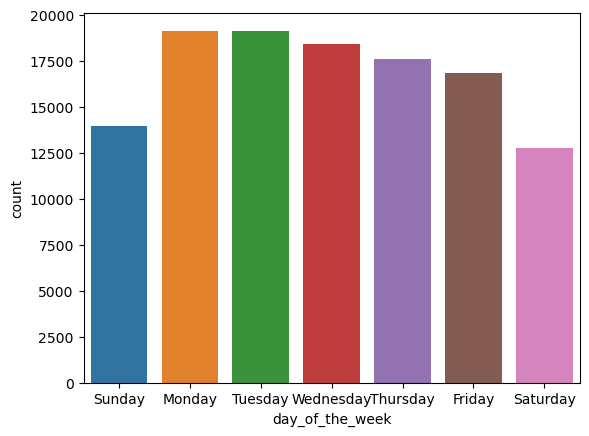

In [35]:
day_order = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

df_vendidos['day_of_the_week'].value_counts()

sns.countplot(data = df_vendidos, x='day_of_the_week', order=day_order)



In [36]:
df_vendidos['day_of_the_week'].value_counts()


Monday       19129
Tuesday      19092
Wednesday    18403
Thursday     17606
Friday       16813
Sunday       13954
Saturday     12744
Name: day_of_the_week, dtype: int64

O dia da semana que houve mais vendas foi na Segunda-feira.

Text(0.5, 0, 'Hour')

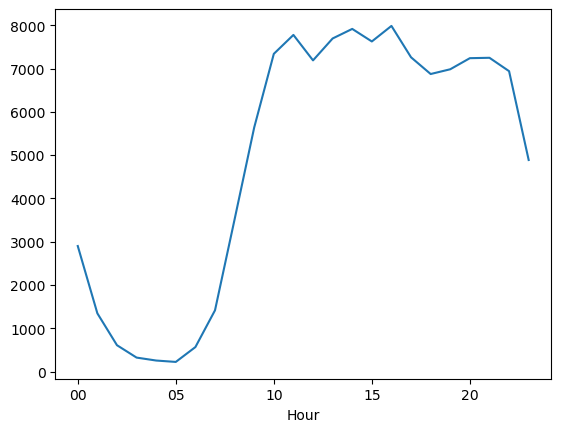

In [37]:
df_vendidos['hour_day'] = df_vendidos['order_purchase_timestamp'].apply(lambda x: x.strftime('%H'))
df_vendidos['hour_day'].value_counts().sort_index().plot()
plt.xlabel('Hour')

In [38]:
df_vendidos['hour_day'].value_counts().sort_values(ascending=False)[0:3]

16    7984
14    7915
11    7776
Name: hour_day, dtype: int64

O horário com mais vendas foi às 16 horas.

#### 5 - O valor do frete influencia na hora de finalizar a compra?

In [39]:
df_frete = df_consolidado.copy()
df_frete.loc[df_frete['freight_value'].isnull()]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
118310,8e24261a7e58791d10cb1bf9da94df5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaN,NaN,2017-12-05 00:00:00,1.0,credit_card,5.0,84.00,41fc647b8c6bd979b1b6364b60471b50,89288,sao bento do sul,SC,7fb04ba6e8b915c62557517d5c1e04ee,1.0,NaN,Anunciam um produto que não tem em estoque e a...,2017-12-07 00:00:00,2017-12-11 10:37:57
118311,c272bcd21c287498b4883c7512019702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaN,NaN,2018-02-16 00:00:00,1.0,credit_card,1.0,97.68,0e634b16e4c585acbd7b2e8276ce6677,11701,praia grande,SP,b6ea5566d6060db04ebe53a1291e4541,3.0,NaN,NaN,2018-02-18 00:00:00,2018-02-20 19:23:56
118312,37553832a3a89c9b2db59701c357ca67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaN,NaN,2017-09-05 00:00:00,1.0,boleto,1.0,132.46,596ed6d7a35890b3fbac54ec01f69685,2318,sao paulo,SP,aaeb804fe1828db8cc3d8b52ec38a1fa,1.0,NaN,Até hoje não recebi meu produto e nem uma resp...,2017-09-10 00:00:00,2017-09-12 17:00:15
118313,d57e15fb07fd180f06ab3926b39edcd2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaN,NaN,2018-02-06 00:00:00,1.0,boleto,1.0,134.38,2349bbb558908e0955e98d47dacb7adb,48607,paulo afonso,BA,519e62c42f33dce5b47ffddf9fde28df,1.0,NaN,Não compre,2018-02-09 00:00:00,2018-02-09 03:22:43
118314,00b1cb0320190ca0daa2c88b35206009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaN,NaN,NaN,2018-09-12 00:00:00,1.0,not_defined,1.0,0.00,4fa4365000c7090fcb8cad5713c6d3db,1151,sao paulo,SP,9c0d840dfe562debfa52a1792bd64bff,1.0,Entregaram produto errado,Comprei dois fones de ouvido com valor de R$ 5...,2018-08-28 00:00:00,2018-08-28 18:25:55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119138,aaab15da689073f8f9aa978a390a69d1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaN,NaN,2018-02-06 00:00:00,1.0,boleto,1.0,210.09,a33e0969408919ba06779f497ead93ec,7025,guarulhos,SP,396e26da77b10734f3f8b5d5515fef4e,1.0,NaN,"UMA BOSTA NAO ENTREGA, E NAO FAZ ESTORNO DO VA...",2018-02-09 00:00:00,2018-02-09 10:12:45
119139,3a3cddda5a7c27851bd96c3313412840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaN,NaN,NaN,2018-10-01 00:00:00,1.0,voucher,1.0,63.89,e90598185d2427a35e32ef241a5c04aa,11075,santos,SP,16d3db296c46b4411dfc5f8bde882e6d,5.0,NaN,NaN,2018-07-24 00:00:00,2018-07-25 16:26:05
119140,a89abace0dcc01eeb267a9660b5ac126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaN,NaN,NaN,2018-09-27 00:00:00,1.0,voucher,1.0,107.13,d05c44a138277ad325d915c6b7ccbcdf,5344,sao paulo,SP,047fd109c

In [40]:
df_frete['porcentagem_frete_preco'] = df_frete['freight_value'] / (df_frete['price'] + df_frete['freight_value']) * 100
df_frete['porcentagem_frete_preco'].describe()

count    118310.000000
mean         21.389071
std          12.987126
min           0.000000
25%          11.877741
50%          18.842408
75%          28.266959
max          96.328294
Name: porcentagem_frete_preco, dtype: float64

In [41]:
pedidos_realizados = df_frete[~df_frete['order_status'].isin(['canceled','unavailable'])]
pedidos_realizados.shape

(117741, 40)

In [42]:
pedidos_cancelados = df_frete.loc[df_frete['order_status']=='canceled']
pedidos_cancelados.shape

(750, 40)

Text(0.5, 1.0, 'Pedidos cancelados')

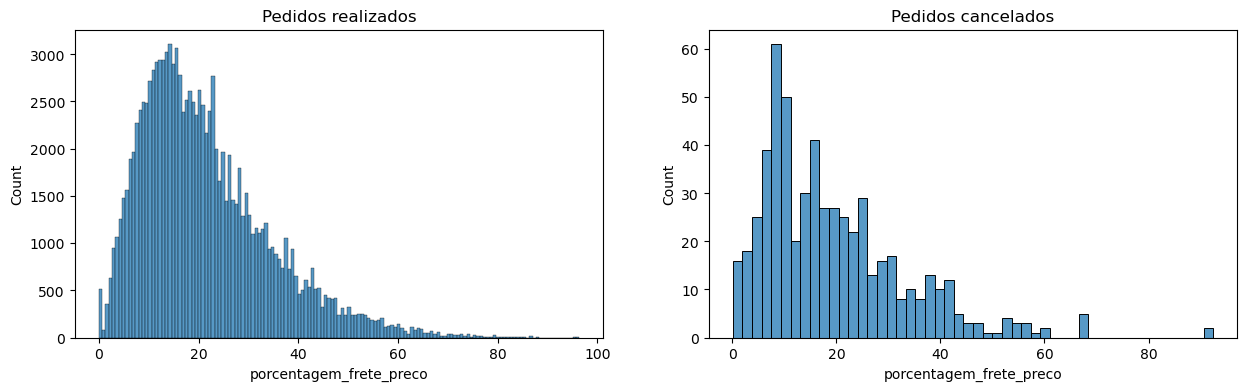

In [43]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)

sns.histplot(pedidos_realizados, x='porcentagem_frete_preco')
plt.title('Pedidos realizados')

plt.subplot(1,2,2)

sns.histplot(pedidos_cancelados, x='porcentagem_frete_preco', bins=50)
plt.title('Pedidos cancelados')


Aparentemente a porcentagem de quanto o frete representa no valor final apresentou a mesma distribuição para pedidos cancelados e pedidos realizados, indício de que não há forte correlação entre o frete e o cancelamento da compra.

#### 6 - Em qual estado o consumidor está pagando o frete mais caro e em qual estado está demorando mais para o produto chegar?


In [44]:
media_frete_estado = df_frete.groupby('customer_state')['porcentagem_frete_preco'].mean()

In [45]:
media_frete_estado.index

Index(['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MG', 'MS',
       'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC',
       'SE', 'SP', 'TO'],
      dtype='object', name='customer_state')

In [46]:
df_date = df_consolidado.loc[:,['price', 'freight_value','order_status','order_purchase_timestamp','order_approved_at','order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date','customer_city', 'customer_state','payment_type']]

In [47]:
df_date.columns

Index(['price', 'freight_value', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_city', 'customer_state', 'payment_type'],
      dtype='object')

In [48]:
time_list = ['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for time in time_list:
    df_date[time] = pd.to_datetime(df_date[time])

In [49]:
df_date['waiting_time'] = df_date['order_delivered_customer_date'] - df_date['order_purchase_timestamp']

In [50]:
df_date['waiting_time'] = df_date['waiting_time'].dt.days

In [51]:
tempo_medio_espera = df_date.groupby('customer_state').waiting_time.mean()

Text(0.5, 0, 'Tempo médio de espera em dias')

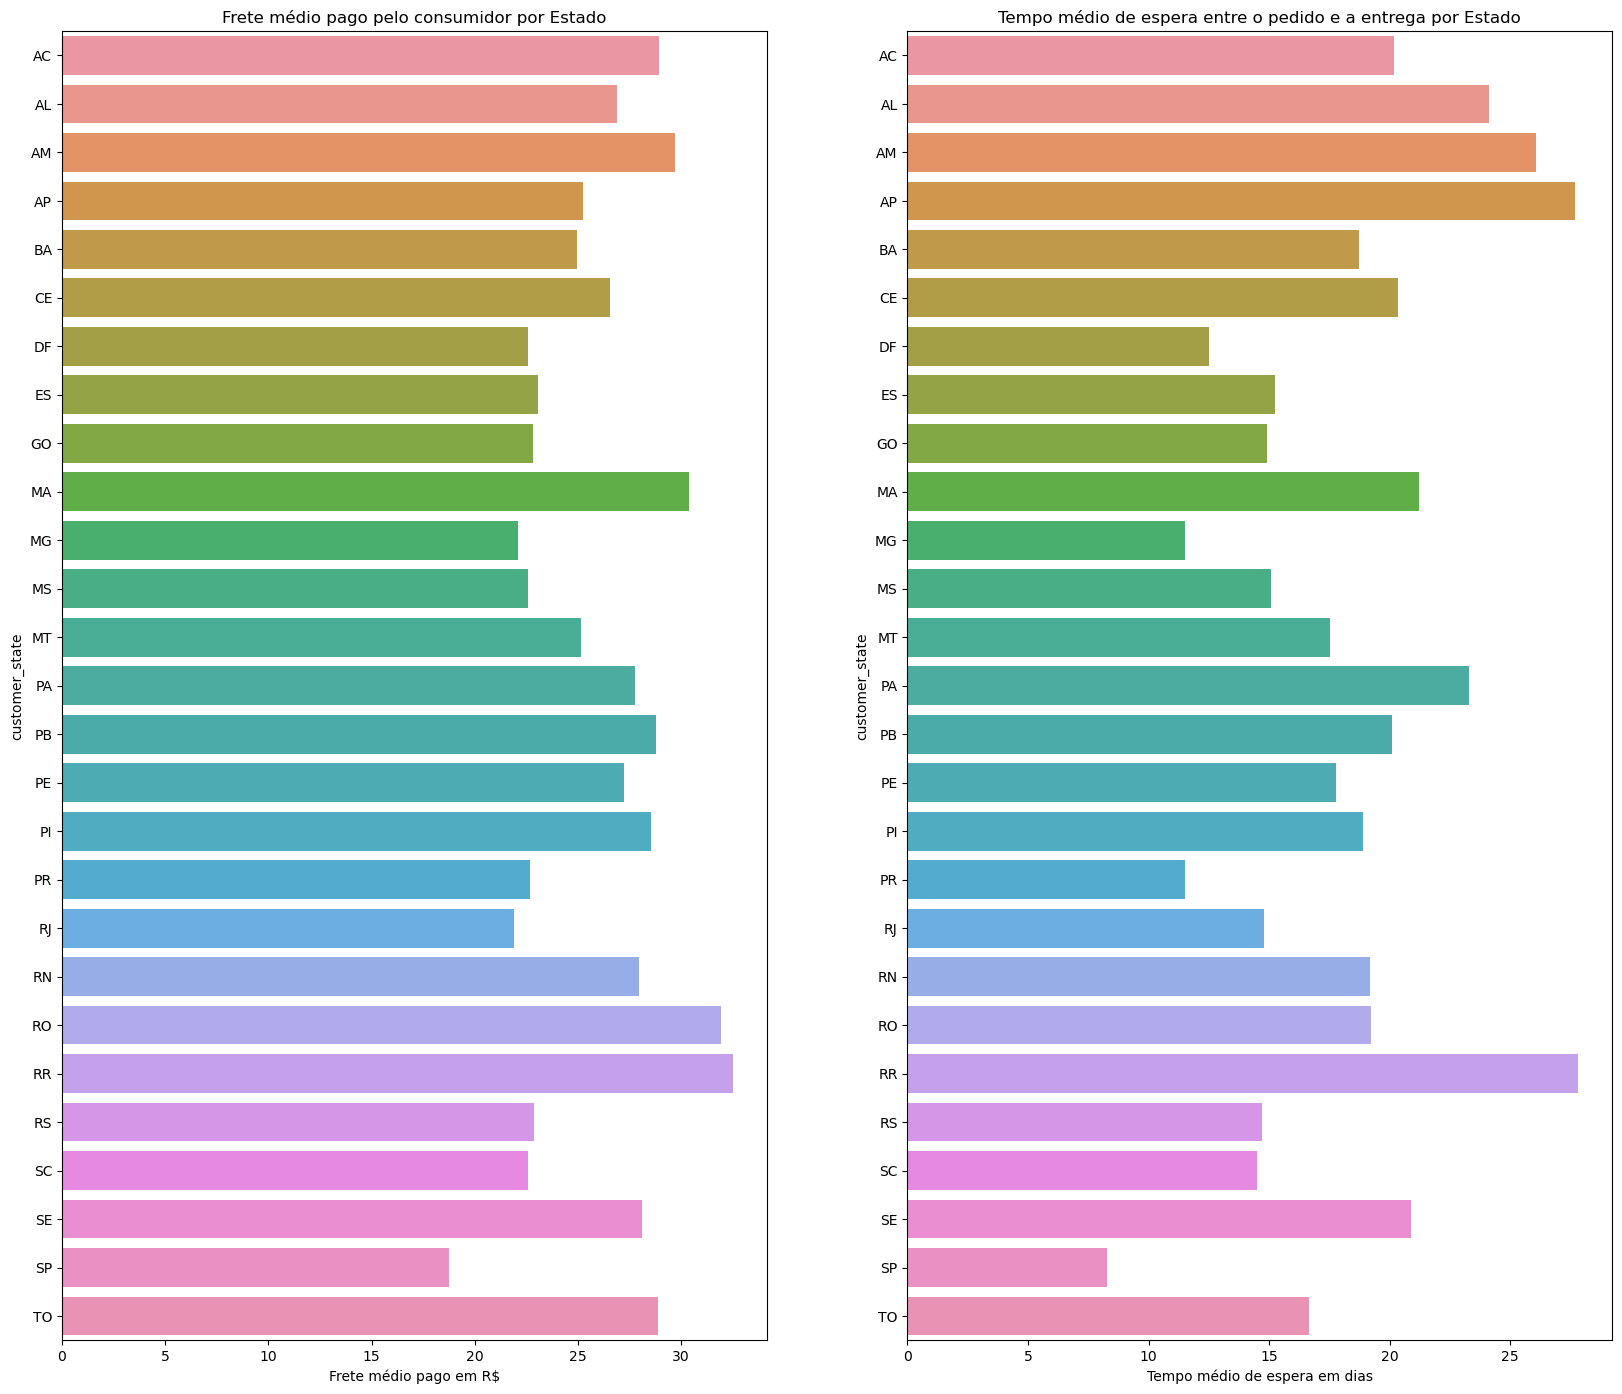

In [52]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

plt.figure(figsize=(20,17))

plt.subplot(1,2,1)
sns.barplot(y=media_frete_estado.index, x=media_frete_estado.values)
plt.title('Frete médio pago pelo consumidor por Estado')
plt.xlabel('Frete médio pago em R$')

plt.subplot(1,2,2)
sns.barplot(y=tempo_medio_espera.index,x=tempo_medio_espera.values)
plt.title('Tempo médio de espera entre o pedido e a entrega por Estado')
plt.xlabel('Tempo médio de espera em dias')

##### É interessante observar que o Estado que pagou menos frete (SP) também é o Estado em que o tempo de espera entre o pedido e a chegada foi o menor. Isso pode ter relação com a infraestrutura e logística do estado.

#### 7 - Qual tipo de pagamento mais utilizado?

<AxesSubplot: xlabel='payment_type', ylabel='count'>

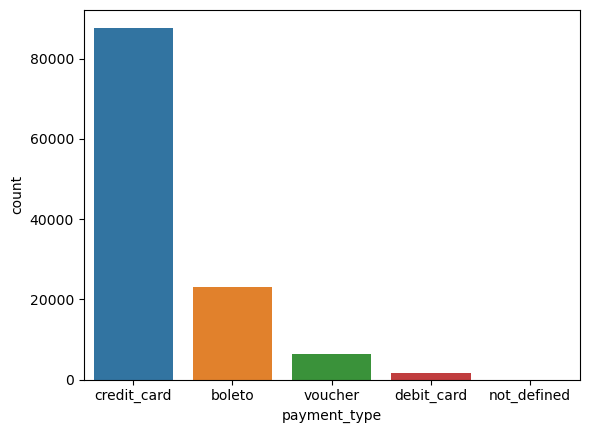

In [53]:
sns.countplot(df_consolidado, x='payment_type')

Como mostra o gráfico acima o meio de pagamento mais utilizado é o de cartão de crédito.

In [54]:
df_date['purchase_year_month'] = df_date['order_purchase_timestamp'].dt.strftime('%Y-%m')

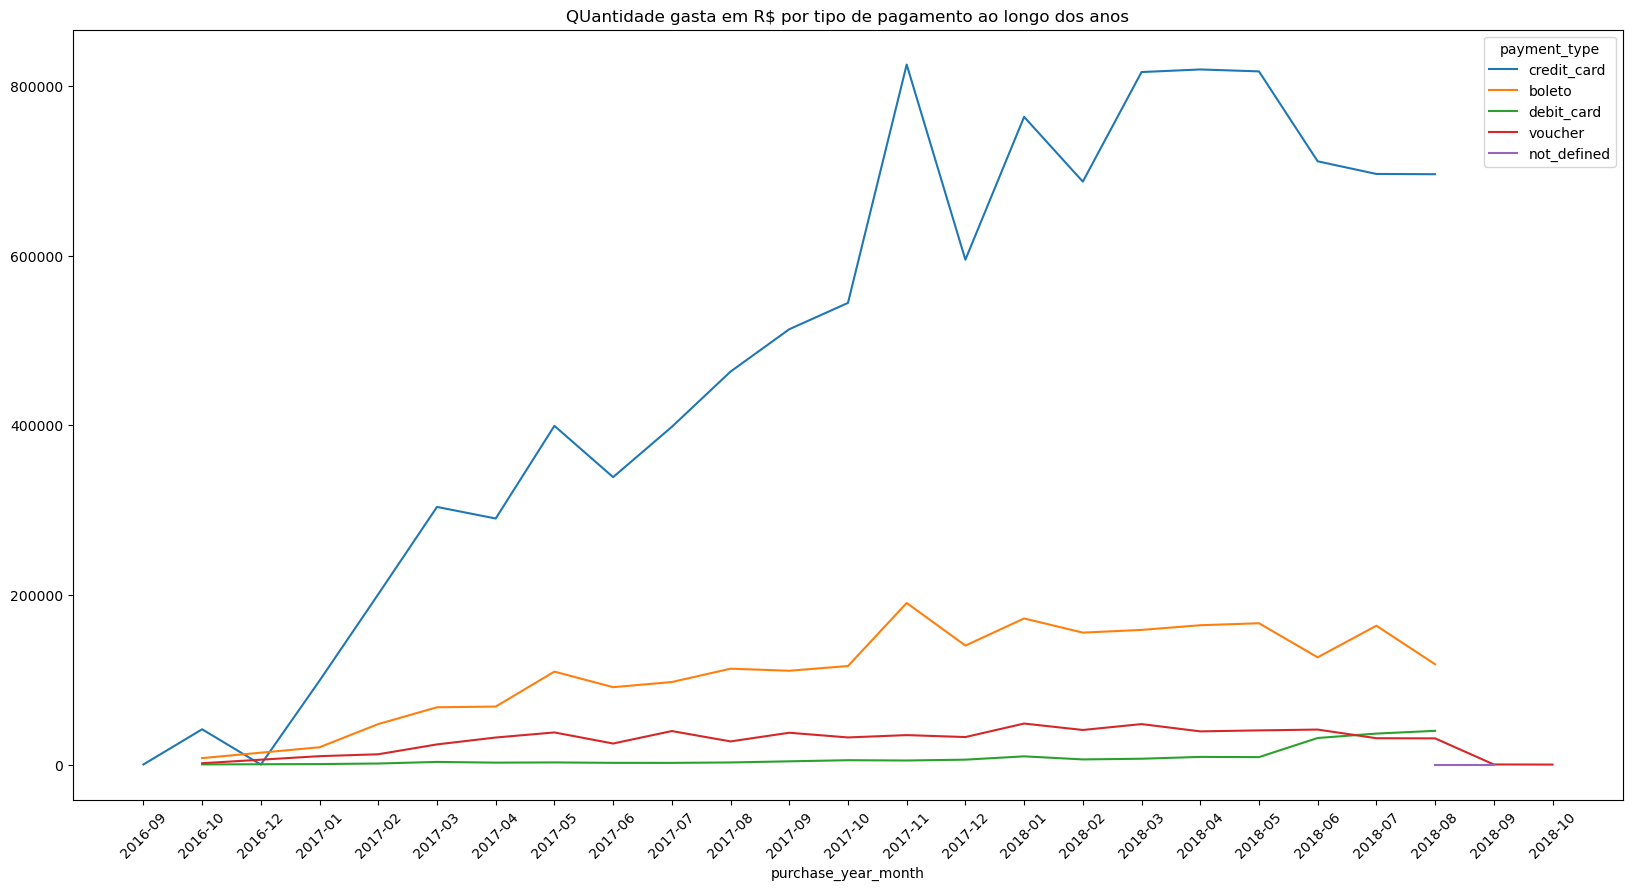

In [55]:
plt.figure(figsize=(20,10))
t = df_date.groupby(['purchase_year_month','payment_type']).price.sum()
sns.lineplot(t,x='purchase_year_month',y=t.values, hue='payment_type')
plt.xticks(rotation=45)
plt.title('QUantidade gasta em R$ por tipo de pagamento ao longo dos anos')
plt.show()


#### Queremos agora prever quais usuários têm maior probabilidade de fazer uma segunda compra em até 30 dias após a realização da primeira. Suponhamos que segundo um estudo feito no passado, estes usuários possuem maior probabilidade de fidelizar na empresa e passar a realizar aquisições mensalmente.

In [56]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [57]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [58]:
df_order_customer = df_orders.merge(df_customers, how='left', on='customer_id')
df_order_customer

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


In [59]:
df_order_customer.order_purchase_timestamp = pd.to_datetime(df_order_customer['order_purchase_timestamp'], errors='coerce')

In [60]:
df_order_customer

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


In [61]:
df_order_customer['data_compra+30'] = df_order_customer['order_purchase_timestamp'] + timedelta(days = 30)

In [62]:
df_order_customer

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,data_compra+30
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-11-01 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-08-23 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-09-07 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-12-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-03-15 21:18:39
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,2017-04-08 09:54:05
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,2018-03-08 12:58:58
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,2017-09-26 14:46:43
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2018-02-07 21:28:27


In [63]:
df_order_customer = df_order_customer.sort_values('order_purchase_timestamp').reset_index(drop=True)
df_order_customer

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,data_compra+30
0,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaN,2016-10-20 00:00:00,b7d76e111c89f7ebf14761390f0f7d17,69309,boa vista,RR,2016-10-04 21:15:19
1,e5fa5a7210941f7d56d0208e4e071d35,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-09-05 00:15:34,2016-10-07 13:17:15,NaN,NaN,2016-10-28 00:00:00,4854e9b3feff728c13ee5fc7d1547e92,99025,passo fundo,RS,2016-10-05 00:15:34
2,809a282bbd5dbcabb6f2f724fca862ec,622e13439d6b5a0b486c435618b2679e,canceled,2016-09-13 15:24:19,2016-10-07 13:16:46,NaN,NaN,2016-09-30 00:00:00,009b0127b727ab0ba422f6d9604487c7,12244,sao jose dos campos,SP,2016-10-13 15:24:19
3,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00,830d5b7aaa3b6f1e9ad63703bec97d23,14600,sao joaquim da barra,SP,2016-10-15 12:16:38
4,71303d7e93b399f5bcd537d124c0bcfa,b106b360fe2ef8849fbbd056f777b4d5,canceled,2016-10-02 22:07:52,2016-10-06 15:50:56,NaN,NaN,2016-10-25 00:00:00,0eb1ee9dba87f5b36b4613a65074337c,2975,sao paulo,SP,2016-11-01 22:07:52
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,392ed9afd714e3c74767d0c4d3e3f477,2823ffda607a2316375088e0d00005ec,canceled,2018-09-29 09:13:03,NaN,NaN,NaN,2018-10-15 00:00:00,9bb92bebd4cb7511e1a02d5e50bc4655,7176,guarulhos,SP,2018-10-29 09:13:03
99437,616fa7d4871b87832197b2a137a115d2,bf6181a85bbb4115736c0a8db1a53be3,canceled,2018-10-01 15:30:09,NaN,NaN,NaN,2018-10-23 00:00:00,634420a0ea42302205032ed44ac7fccc,27175,pirai,RJ,2018-10-31 15:30:09
99438,a2ac6dad85cf8af5b0afb510a240fe8c,4c2ec60c29d10c34bd49cb88aa85cfc4,canceled,2018-10-03 18:55:29,NaN,NaN,NaN,2018-10-16 00:00:00,af5454198a97379394cacf676e1e96cb,11900,registro,SP,2018-11-02 18:55:29
99439,b059ee4de278302d550a3035c4cdb740,856336203359aa6a61bf3826f7d84c49,canceled,2018-10-16 20:16:02,NaN,NaN,NaN,2018-11-12 00:00:00,262e1f1e26e92e86375f86840b4ffd63,64600,picos,PI,2018-11-15 20:16:02


In [64]:
df_order_customer.customer_unique_id.value_counts()

8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
ca77025e7201e3b30c44b472ff346268     7
1b6c7548a2a1f9037c1fd3ddfed95f33     7
6469f99c1f9dfae7733b25662e7f1782     7
                                    ..
2c359c1f6018a4df4529036d3d34a96a     1
e42fa91c4d4cb98492840ffe16df8d5d     1
a0838488ea02b239afbdb7ebfb480e2d     1
65413463e8c6b0f33e29e18bebac31db     1
87ab9fec999db8bd5774917de3cdf01c     1
Name: customer_unique_id, Length: 96096, dtype: int64

In [65]:
df_order_customer[df_order_customer.customer_unique_id == '8d50f5eadf50201ccdcedfb9e2ac8455']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,data_compra+30
9730,5d848f3d93a493c1c8955e018240e7ca,0e4fdc084a6b9329ed55d62dcd653ccf,shipped,2017-05-15 23:30:03,2017-05-15 23:42:34,2017-05-17 10:42:20,NaN,2017-05-26 00:00:00,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,2017-06-14 23:30:03
13728,369634708db140c5d2c4e365882c443a,b2b13de0770e06de50080fea77c459e6,delivered,2017-06-18 22:56:48,2017-06-18 23:10:19,2017-06-19 20:12:26,2017-06-23 12:55:50,2017-07-07 00:00:00,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,2017-07-18 22:56:48
17077,5837a2c844decae8a778657425f6d664,31dd055624c66f291578297a551a6cdf,unavailable,2017-07-17 22:11:13,2017-07-17 22:23:46,NaN,NaN,2017-08-17 00:00:00,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,2017-08-16 22:11:13
17280,4f62d593acae92cea3c5662c76122478,dfb941d6f7b02f57a44c3b7c3fefb44b,delivered,2017-07-18 23:10:58,2017-07-18 23:23:26,2017-07-20 19:00:02,2017-07-21 16:19:40,2017-07-31 00:00:00,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,2017-08-17 23:10:58
18028,bf92c69b7cc70f7fc2c37de43e366173,42dbc1ad9d560637c9c4c1533746f86d,delivered,2017-07-24 22:11:50,2017-07-24 22:25:14,2017-07-26 01:42:03,2017-07-31 16:59:58,2017-08-15 00:00:00,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,2017-08-23 22:11:50
19588,519203404f6116d406a970763ee75799,1c62b48fb34ee043310dcb233caabd2e,delivered,2017-08-05 08:59:43,2017-08-05 09:10:13,2017-08-07 18:50:00,2017-08-09 15:22:28,2017-08-25 00:00:00,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,2017-09-04 08:59:43
23977,e3071b7624445af6e4f3a1b23718667d,0bf8bf19944a7f8b40ba86fef778ca7c,delivered,2017-09-05 22:14:52,2017-09-05 22:30:56,2017-09-06 15:26:12,2017-09-11 13:27:49,2017-09-22 00:00:00,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,2017-10-05 22:14:52
30348,cd4b336a02aacabd0ef22f6db711f95e,89be66634d68fa73a95499b6352e085d,delivered,2017-10-18 23:25:04,2017-10-19 00:36:08,2017-10-20 17:11:50,2017-10-23 18:33:01,2017-10-30 00:00:00,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,2017-11-17 23:25:04
31839,89d9b111d2b990deb5f5f9769f92800b,9a1afef458843a022e431f4cb304dfe9,delivered,2017-10-29 16:58:02,2017-10-29 17:10:09,2017-10-30 15:58:52,2017-10-31 15:33:47,2017-11-10 00:00:00,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,2017-11-28 16:58:02
35984,b850a16d8faf65a74c51287ef34379ce,1bd3585471932167ab72a84955ebefea,delivered,2017-11-22 20:01:53,2017-11-22 20:12:32,2017-11-24 16:07:56,2017-11-27 18:49:13,2017-12-04 00:00:00,8d50f5eadf50201ccdcedfb9e2ac8455,4045,sao paulo,SP,2017-12-22 20:01:53


In [66]:
lista_df =df_order_customer.values.tolist()

In [67]:
len(lista_df)

99441

In [68]:
segunda_compra = []

for linha in lista_df:
    qtd_compra = 0
    for comparar in lista_df:
        if linha[8] == comparar[8] and comparar[3] > linha[3] and comparar[3] <= linha[12]:
            qtd_compra += 1
    if qtd_compra > 0:
        segunda_compra.append(1)
    else:
        segunda_compra.append(0)


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\danil\anaconda3\envs\DS\Lib\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\danil\AppData\Local\Temp\ipykernel_17572\4012089768.py", line -1, in <module>
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\danil\anaconda3\envs\DS\Lib\site-packages\IPython\core\interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\danil\anaconda3\envs\DS\Lib\site-packages\IPython\core\ultratb.py", line 1118, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\danil\anaconda3\envs\DS\Lib\site-packages\IPython\core\ultratb.py", line 1012, in structured_traceback
    return VerboseTB.s

In [ ]:
len(segunda_compra)

99441

In [ ]:
df_order_customer['segunda_compra'] = segunda_compra

In [ ]:
df_order_customer[df_order_customer.customer_unique_id == '8d50f5eadf50201ccdcedfb9e2ac8455'][['order_purchase_timestamp','data_compra+30','segunda_compra']]

,order_purchase_timestamp,data_compra+30,segunda_compra
9730,2017-05-15 23:30:03,2017-06-14 23:30:03,0
13728,2017-06-18 22:56:48,2017-07-18 22:56:48,1
17077,2017-07-17 22:11:13,2017-08-16 22:11:13,1
17280,2017-07-18 23:10:58,2017-08-17 23:10:58,1
18028,2017-07-24 22:11:50,2017-08-23 22:11:50,1
19588,2017-08-05 08:59:43,2017-09-04 08:59:43,0
23977,2017-09-05 22:14:52,2017-10-05 22:14:52,0
30348,2017-10-18 23:25:04,2017-11-17 23:25:04,1
31839,2017-10-29 16:58:02,2017-11-28 16:58:02,1
35984,2017-11-22 20:01:53,2017-12-22 20:01:53,0


#### Importar para csv

In [ ]:
df_order_customer.to_csv('olist_segunda_compra.csv', sep=',', encoding='UTF-8', index=False)

In [ ]:
df_order_customer.segunda_compra.value_counts(normalize=True)

0    0.98576
1    0.01424
Name: segunda_compra, dtype: float64

In [ ]:
segunda_compra_estado = df_order_customer[df_order_customer.segunda_compra == 1].customer_state.value_counts().sort_index()
segunda_compra_estado

AC      1
AL      6
AM      3
AP      1
BA     41
CE      9
DF     33
ES     37
GO     21
MA      6
MG    159
MS     16
MT     15
PA     15
PB     11
PE     20
PI      5
PR     79
RJ    205
RN      5
RO      4
RS     83
SC     43
SE      5
SP    590
TO      3
Name: customer_state, dtype: int64

In [ ]:
compra_estado = df_order_customer.customer_state.value_counts().sort_index()
compra_estado

AC       81
AL      413
AM      148
AP       68
BA     3380
CE     1336
DF     2140
ES     2033
GO     2020
MA      747
MG    11635
MS      715
MT      907
PA      975
PB      536
PE     1652
PI      495
PR     5045
RJ    12852
RN      485
RO      253
RR       46
RS     5466
SC     3637
SE      350
SP    41746
TO      280
Name: customer_state, dtype: int64

In [ ]:
porcentagem_retorno = (segunda_compra_estado/compra_estado * 100).sort_values(ascending=False)

<AxesSubplot: >

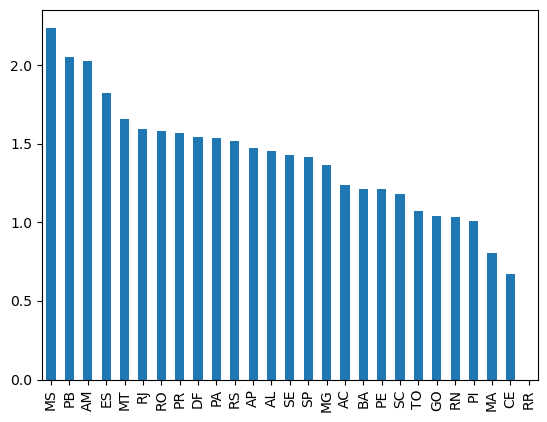

In [ ]:
porcentagem_retorno.plot(kind='bar')